In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from flareTools import id_segments

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec14/'

Compare flare pipeline results with Lupita's working picking out flares by eye from GJ1243.

In [2]:
tic_gaia_table = pd.read_csv('ticGAIA14.csv')
param_table = pd.read_csv('14_param_out.csv')
flare_table = pd.read_csv('14_flare_out.csv')
print(len(tic_gaia_table), len(flare_table), len(param_table))

19994 5069 30017


In [3]:
flare_gaia_table = pd.merge(tic_gaia_table, flare_table, on='TIC')
print(len(flare_gaia_table))
flare_gaia_table.columns

5082


Index(['Unnamed: 0_x', 'TIC', 'dist', 'lum', 'G_BPbrmag', 'G_RPmag', 'G_mag',
       'Unnamed: 0_y', 'file', 't0', 't1', 'med', 'peak', 'ed', 'ed_err', 'mu',
       'std', 'g_amp', 'mu_err', 'std_err', 'g_amp_err', 'tpeak', 'fwhm',
       'f_amp', 'tpeak_err', 'fwhm_err', 'f_amp_err', 'f_chisq', 'g_chisq'],
      dtype='object')

In [4]:
df = flare_gaia_table
GJ1243_TIC = 273589987
filename = param_table[param_table['TIC'] == GJ1243_TIC]['file'].values[0]
print(filename)

tess2019198215352-s0014-0000000273589987-0150-s_lc.fits


In [5]:
tic_gaia_table[tic_gaia_table['TIC'] == GJ1243_TIC]

,Unnamed: 0,TIC,dist,lum,G_BPbrmag,G_RPmag,G_mag
13261,13261,273589987,NaN,NaN,NaN,NaN,NaN
19993,19993,273589987,11.9787,4.235019e+30,13.1684,10.3313,11.5509


In [6]:
# Flare events found by eye by Lupita
fbeye = pd.read_csv('gj1243_tess_flares.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]
t_starts = fbeye.loc[:,'t_start'].values
t_stops = fbeye.loc[:,'t_stop'].values
flux_peak = fbeye.loc[:,'Flux_peak'].values

Text(0, 0.5, 'Normalized Flux')

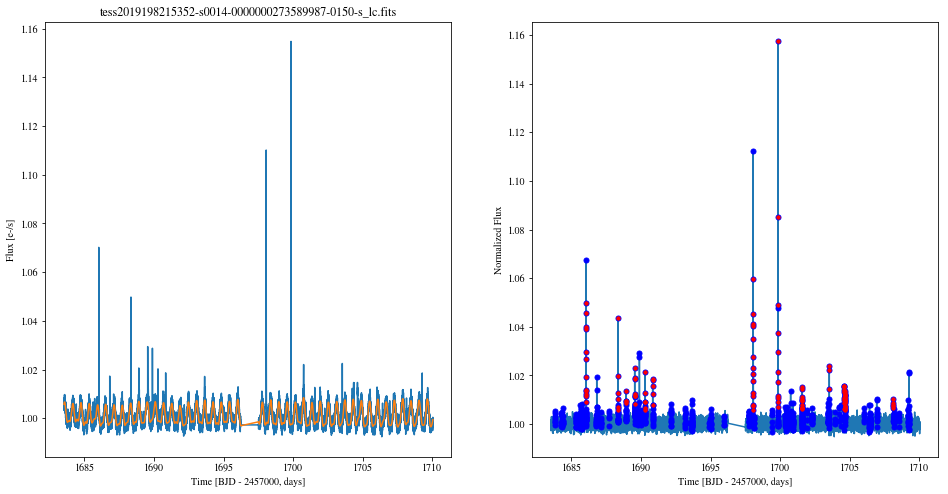

In [7]:
tstart = df[df['file'] == filename]['t0'].values
tstop = df[df['file'] == filename]['t1'].values

fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)

with fits.open(path+filename, mode='readonly') as hdulist:
        tess_bjd = hdulist[1].data['TIME']
        pdcsap_flux = hdulist[1].data['PDCSAP_FLUX']
        pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
        quality = hdulist[1].data['QUALITY']
        
smo, var = np.loadtxt(path+filename+'.gp')
ok_cut = (quality == 0) & (~np.isnan(tess_bjd)) & (~np.isnan(pdcsap_flux)) & (~np.isnan(pdcsap_flux_error))

dt_limit = 12/24 # 12 hours
trim = 4/24 # 4 hours
istart, istop = id_segments(tess_bjd[ok_cut], dt_limit, dt_trim=trim)

time_c = np.array([])
flux_c = np.array([])
error_c = np.array([])

for seg_idx in range(len(istart)):
    tess_bjd_seg = tess_bjd[ok_cut][istart[seg_idx]:istop[seg_idx]]
    pdcsap_flux_seg = pdcsap_flux[ok_cut][istart[seg_idx]:istop[seg_idx]]
    pdcsap_flux_error_seg = pdcsap_flux_error[ok_cut][istart[seg_idx]:istop[seg_idx]]

    time_c = np.concatenate((time_c, tess_bjd_seg), axis=0)
    flux_c = np.concatenate((flux_c, pdcsap_flux_seg), axis=0)
    error_c = np.concatenate((error_c, pdcsap_flux_error_seg), axis=0)

median = np.nanmedian(flux_c)

axes[0].plot(time_c, flux_c/median)
axes[0].plot(time_c, smo)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')
axes[0].set_title(filename)

x = time_c
y = flux_c/median - smo + 1
axes[1].plot(x, y)

for idx in range(len((t_starts))):
    indices = np.where((x >= t_starts[idx]) & (x <= t_stops[idx]))[0]
    axes[1].plot(x[indices], y[indices], 'o', color='b', markersize=5)
for idx in range(len((tstart))):
    indices = np.where((x >= tstart[idx]) & (x <= tstop[idx]))[0]
    axes[1].plot(x[indices], y[indices], 'o', color='r', markersize=3)
    
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Normalized Flux')

Looks like our pipeline definitely caught all of the big flares. The only exception is the flare around T=1690. Our pipeline missed this because it the spike covers only two data points. The change point analysis function requres at least 3.

Beta = -0.011399767260850627


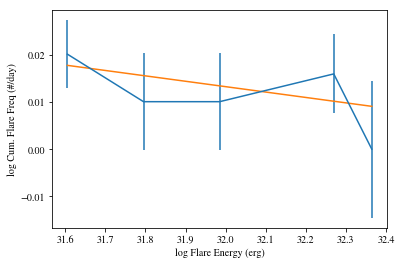

In [32]:
from scipy.optimize import curve_fit

# Construct a FFD and compare with figure 6 of Davenport 2016

# GJ1243 isn't in the TESS-GAIA crossmatch for some reason. Will need to go to MAST and look it up manually

# Get the energies of the flares
ed = (df['ed'].values*u.day).to(u.s)
energy = (ed*df['lum']*u.erg/u.s).value
df['energy'] = energy
df_gj1243 = df[df['TIC'] == GJ1243_TIC]
df_gj1243 = df_gj1243[np.isfinite(df_gj1243['energy'])]

en = df_gj1243['energy']
bins = np.logspace(np.log10(np.min(en)), np.log10(np.max(en)), num=10)
hist, bins = np.histogram(en, bins=bins)
bins = 0.5*(bins[1:] + bins[:-1])

mask = hist > 0
logX = np.log10(bins[mask])
logY = np.log10(hist[mask])
errorY = 0.434*np.sqrt(hist[mask])/hist[mask]

# Convert to flares/day
logY = logY/30
errorY = errorY/30

# Fit a power law
def linear(x, p1, p2):
    return p1*x + p2
popt, pcov = curve_fit(linear, logX, logY, p0=(-1, 1), sigma=errorY)
beta = popt[0]
print('Beta = ' + str(beta))

plt.errorbar(logX, logY, yerr=errorY)
plt.xlabel('log Flare Energy (erg)')
plt.ylabel('log Cum. Flare Freq (#/day)')

xmodel = np.linspace(np.min(logX), np.max(logX))
ymodel = popt[0]*xmodel + popt[1]

plt.plot(xmodel, ymodel)

In [23]:
df_gj1243['t0']

3768    1686.028432
3769    1688.340960
3770    1688.903466
3771    1689.543752
3772    1690.284038
3773    1690.836822
3774    1698.060509
3775    1699.842459
3776    1701.549408
3777    1703.529968
3778    1704.613303
3779    1704.648026
3780    1708.141086
Name: t0, dtype: float64